In [1]:
import numpy as np

def buildLine(W, b, start, end, size = 100):
    """
    构建一条指定的直线
    args:
        W - 权重系数
        b - 偏移量
        start - 最小值
        end - 最大值
        size - 组成线的点的数量
        w0 * x0 + w1 * x1 + b = 0
    """
    x0 = np.linspace(start, end, size)
    if W[1] == 0:
        x0 = np.ones(size) * (-b / W[0])
        x1 = np.zeros(size)
    else:
        x1 = -(b + W[0] * x0) / W[1]
    return x0, x1

def ellipse(a, b, start, end, size = 100):
    np.random.seed(0)
    X = np.random.uniform(start, end, (size, 2))
    y = np.power(X[:, 0], 2) / (a * a) + np.power(X[:, 1], 2) / (b * b) - 1
    y = np.sign(y)
    return X, y

start, end = -10, 10
a, b = 9, 4
X, y = ellipse(a, b, start, end)

原空间：

<IPython.core.display.Javascript object>


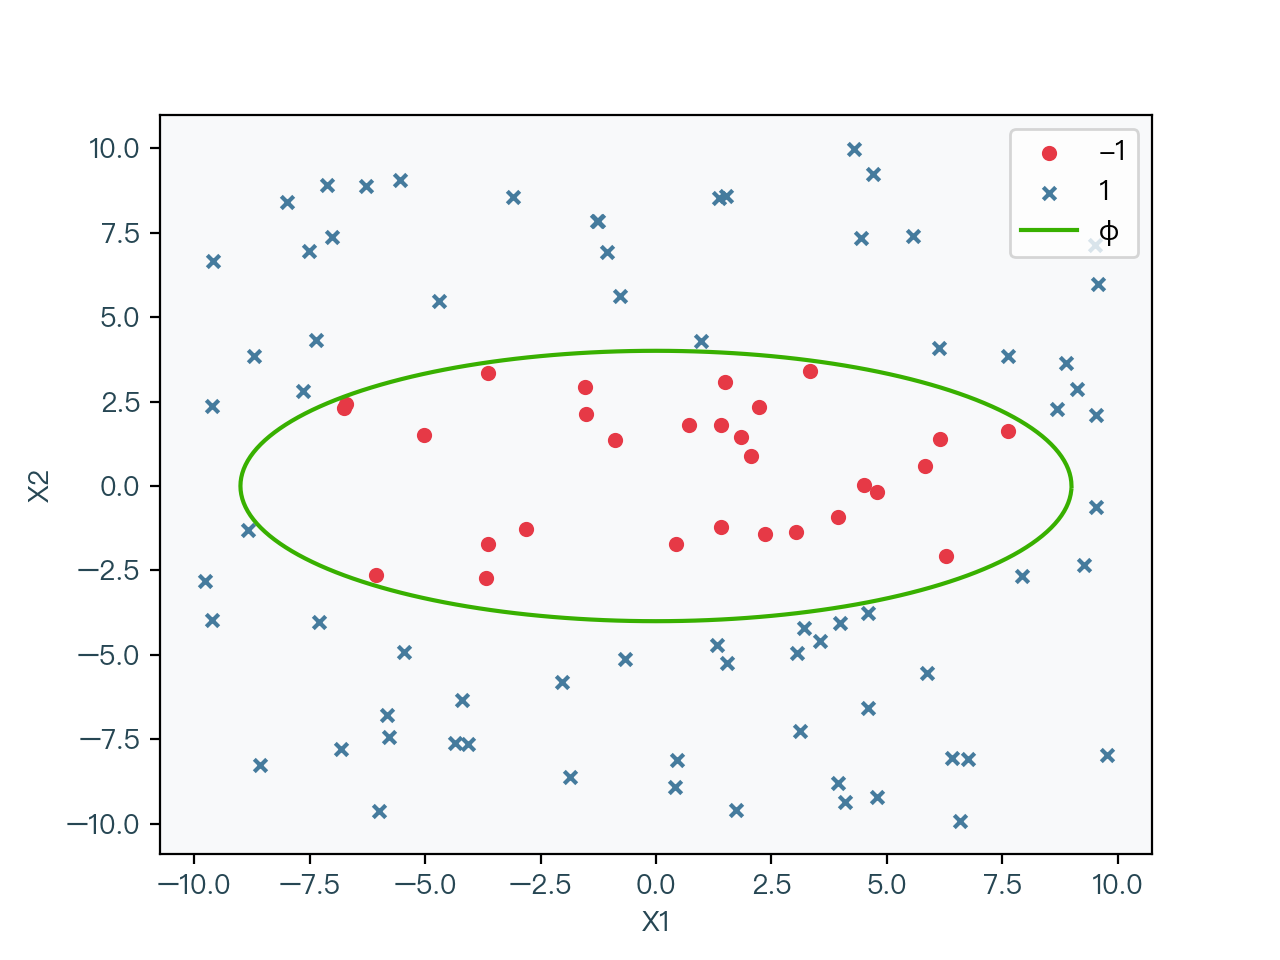

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

theta = np.arange(0, 2 * np.pi, np.pi / 100)
p3, = plt.plot(a * np.cos(theta), b * np.sin(theta), color='#38b000')

ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2, p3], ["-1", "1", "φ"], loc="upper right")
plt.show()

非线性转换：

In [3]:
Z = np.power(X, 2)

新空间：

<IPython.core.display.Javascript object>


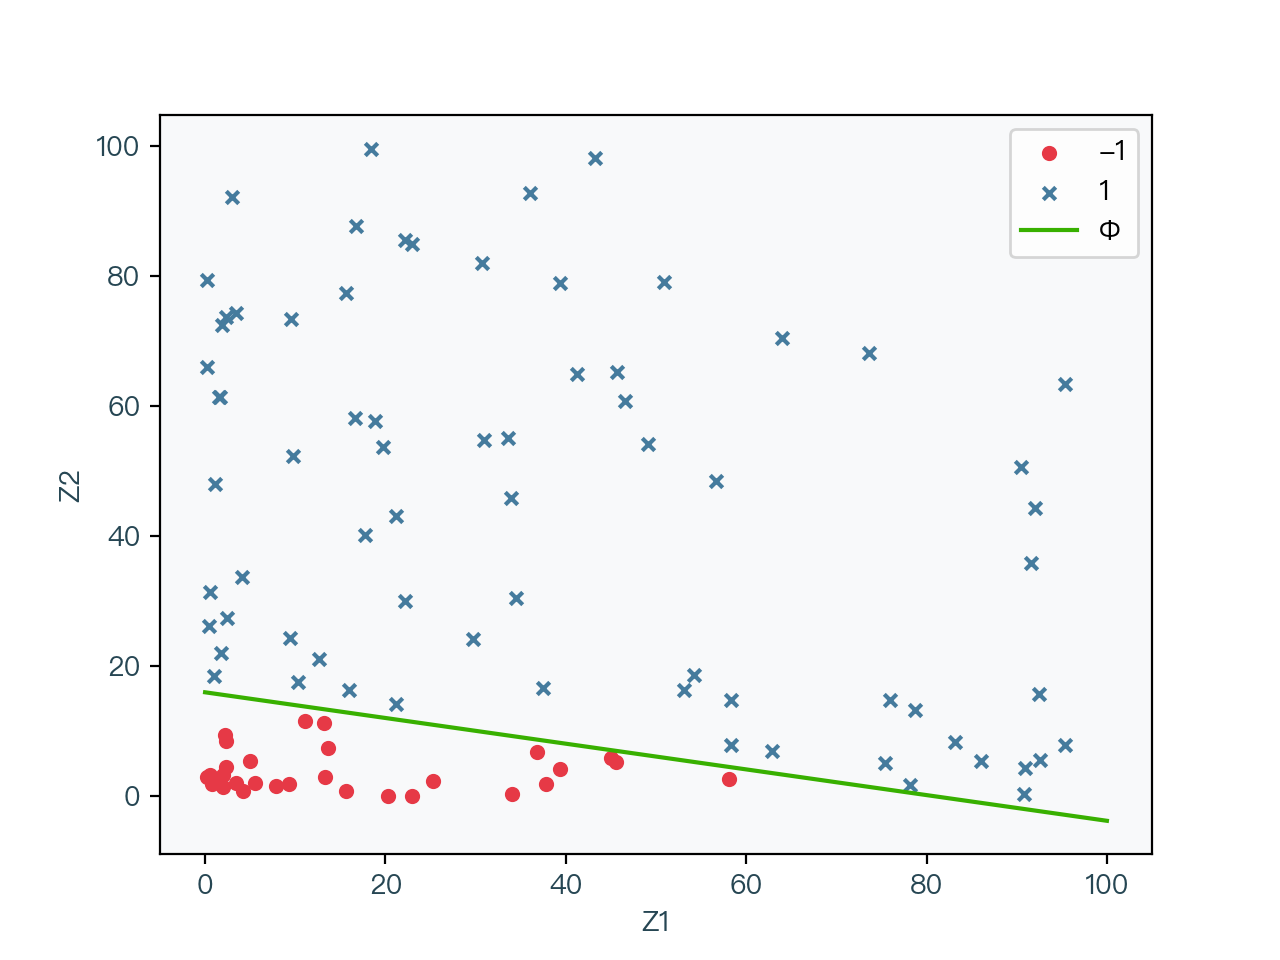

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x1 = Z[y==-1][:, 0]
y1 = Z[y==-1][:, 1]
x2 = Z[y==1][:, 0]
y2 = Z[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

x3, y3 = buildLine([1 / (a * a), 1 / (b * b)], -1, 0, 100)
p3, = plt.plot(x3, y3, '#38b000')

ax.set_xlabel('Z1', color='#264653')
ax.set_ylabel('Z2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2, p3], ["-1", "1", "Φ"], loc="upper right")
plt.show()

生成样例数据：

In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features = 2, n_informative = 2, n_redundant = 0, n_samples = 100, n_classes = 2, random_state = 0)
y[y == 0] = -1

非线性支持向量机实现：

In [6]:
import numpy as np

class SMO:
    """
    支持向量机
    序列最小优化算法实现（Sequential minimal optimization/SMO）
    """

    def __init__(self, X, y, kernel, degree = 3, coef0 = 0.0, gamma = 1.0):
        # 训练样本特征矩阵（N * p）
        self.X = X
        # 训练样本标签向量（N * 1）
        self.y = y
        # 拉格朗日乘子向量（N * 1）
        self.alpha = np.zeros(X.shape[0])
        # 误差向量，默认为负的标签向量（N * 1）
        self.errors = -y
        # 偏移量 
        self.b = 0
        # 代价值
        self.cost = -np.inf
        # 核函数
        self.kernel = kernel
        # 核函数相关参数
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma

    def fit(self, C = 1, tol = 1e-4):
        """
        算法来自 John C. Platt 的论文
        https://www.microsoft.com/en-us/research/uploads/prod/1998/04/sequential-minimal-optimization.pdf
        """
        # 更新变化次数
        numChanged = 0
        # 是否检查全部
        examineAll = True
        while numChanged > 0 or examineAll:
            numChanged = 0
            if examineAll:
                for idx in range(X.shape[0]):
                    numChanged += self.update(idx, C)
            else:
                for idx in range(X.shape[0]):
                    if self.alpha[idx] <= 0:
                        continue
                    numChanged += self.update(idx, C)
            if examineAll:
                examineAll = False
            elif numChanged == 0:
                examineAll = True
            # 计算代价值
            cost = self.calcCost()
            if self.cost > 0:
                # 当代价值的变化小于容许的范围时结束算法
                rate = (cost - self.cost) / self.cost
                if rate <= tol:
                    break
            self.cost = cost

    def update(self, idx, C = 1):
        """
        对下标为 idx 的拉格朗日乘子进行更新
        """
        X = self.X
        y = self.y
        alpha = self.alpha
        # 检查当前拉格朗日乘子是否满足KKT条件，满足条件则直接返回 0
        if self.checkKKT(idx, C):
            return 0
        if len(alpha[(alpha != 0)]) > 1:
            # 按照｜E1 - E2｜最大的原则寻找第二个待优化的拉格朗日乘子的下标
            jdx = self.selectJdx(idx)
            # 对下标为 idx、jdx 的拉格朗日乘子进行更新，当成功更新时直接返回 1
            if self.updateAlpha(idx, jdx, C):
                return 1
        # 当未更新成功时，遍历不为零的拉格朗日乘子进行更新
        for jdx in range(X.shape[0]):
            if alpha[jdx] == 0:
                continue
            # 对下标为 idx、jdx 的拉格朗日乘子进行更新，当成功更新时直接返回 1
            if self.updateAlpha(idx, jdx, C):
                return 1
        # 当依然没有没有更新成功时，遍历为零的拉格朗日乘子进行更新
        for jdx in range(X.shape[0]):
            if alpha[jdx] != 0:
                continue
            # 对下标为 idx、jdx 的拉格朗日乘子进行更新，当成功更新时直接返回 1
            if self.updateAlpha(idx, jdx, C):
                return 1
        # 依然没有更新时返回 0
        return 0

    def selectJdx(self, idx):
        """
        寻找第二个待优化的拉格朗日乘子的下标
        """
        errors = self.errors
        if errors[idx] > 0:
            # 当误差项大于零时，选择误差向量中最小值的下标
            return np.argmin(errors)
        elif errors[idx] < 0:
            # 当误差项小于零时，选择误差向量中最大值的下标
            return np.argmax(errors)
        else:
            # 当误差项等于零时，选择误差向量中最大值和最小值的绝对值最大的下标
            minJdx = np.argmin(errors)
            maxJdx = np.argmax(errors)
            if max(np.abs(errors[minJdx]), np.abs(errors[maxJdx])) - errors[minJdx]:
                return minJdx
            else:
                return maxJdx
    
    def calcB(self):
        """
        计算偏移量
        分别计算每一个拉格朗日乘子不为零对应的偏移量后取其平均值
        """
        X = self.X
        y = self.y
        alpha = self.alpha
        alpha_gt = alpha[alpha > 0]
        # 拉格朗日乘子向量中不为零的数量
        alpha_gt_len = len(alpha_gt)
        # 全部为零时直接返回 0
        if alpha_gt_len == 0:
            return 0
        # b = y - Wx，具体算法请参考文章中的说明
        X_gt = X[alpha > 0]
        y_gt = y[alpha > 0]
        
        s = 0
        for idx in range(X_gt.shape[0]):
            ss = 0
            for jdx in range(X_gt.shape[0]):
                ss += alpha_gt[jdx] * y_gt[jdx] * self.kernel(X_gt[jdx], X_gt[idx], self.degree, self.coef0, self.gamma)
            s += y_gt[idx] - ss
        return s / alpha_gt_len

    def calcCost(self):
        """
        计算代价值
        按照文章中的算法计算即可
        """
        X = self.X
        y = self.y
        alpha = self.alpha
        cost = 0
        for idx in range(X.shape[0]):
            for jdx in range(X.shape[0]):
                cost = cost + (y[idx] * y[jdx] * self.kernel(X[idx], X[jdx], self.degree, self.coef0, self.gamma) * alpha[idx] * alpha[jdx])
        return np.sum(alpha) - cost / 2

    def checkKKT(self, idx, C = 1):
        """
        检查下标为 idx 的拉格朗日乘子是否满足 KKT 条件
        1. alpha >= 0
        2. alpha <= C
        3. y * f(x) - 1 >= 0
        4. alpha * (y * f(x) - 1) = 0
        """
        y = self.y
        errors = self.errors
        alpha = self.alpha
        r = errors[idx] * y[idx]
        if (alpha[idx] > 0 and alpha[idx] < C and r == 0) or (alpha[idx] == 0 and r > 0) or (alpha[idx] == C and r < 0):
            return True
        return False

    def calcU(self, idx, jdx, C = 1):
        """
        计算拉格朗日乘子上界，使两个待优化的拉格朗日乘子同时大于等于0
        按照文章中的算法计算即可
        """
        y = self.y
        alpha = self.alpha
        if y[idx] * y[jdx] == 1:
            return max(0, alpha[jdx] + alpha[idx] - C)
        else:
            return max(0.0, alpha[jdx] - alpha[idx])

    def calcV(self, idx, jdx, C = 1):
        """
        计算拉格朗日乘子下界，使两个待优化的拉格朗日乘子同时大于等于0
        按照文章中的算法计算即可
        """
        y = self.y
        alpha = self.alpha
        if y[idx] * y[jdx] == 1:
            return min(C, alpha[jdx] + alpha[idx])
        else:
            return min(C, C + alpha[jdx] - alpha[idx])

    def updateAlpha(self, idx, jdx, C = 1):
        """
        对下标为 idx、jdx 的拉格朗日乘子进行更新
        按照文章中的算法计算即可
        """
        if idx == jdx:
            return False
        X = self.X
        y = self.y
        alpha = self.alpha
        errors = self.errors
        # idx 的误差项
        Ei = errors[idx]
        # jdx 的误差项
        Ej = errors[jdx]
        U = self.calcU(idx, jdx, C)
        V = self.calcV(idx, jdx, C)
        if U == V:
            return False
        Kii = self.kernel(X[idx], X[idx], self.degree, self.coef0, self.gamma)
        Kjj = self.kernel(X[jdx], X[jdx], self.degree, self.coef0, self.gamma)
        Kij = self.kernel(X[idx], X[jdx], self.degree, self.coef0, self.gamma)
        # 计算 K
        K = Kii + Kjj - 2 * Kij
        oldAlphaIdx = alpha[idx]
        oldAlphaJdx = alpha[jdx]
        oldB = self.b
        s = y[idx] * y[jdx]
        if K > 0:
            # 计算 jdx 的新拉格朗日乘子
            newAlphaJdx = oldAlphaJdx + y[jdx] * (Ei - Ej) / K
            if newAlphaJdx < U:
                # 当新值超过上界时，修改其为上界
                newAlphaJdx = U
            if newAlphaJdx > V:
                # 当新值低于下界时，修改其为下界
                newAlphaJdx = V
        else:
            fi = y[idx] * (Ei + oldB) - oldAlphaIdx * Kii - s * oldAlphaJdx * Kij
            fj = y[jdx] * (Ej + oldB) - s * oldAlphaIdx * Kij - oldAlphaJdx * Kjj
            Vv = oldAlphaIdx + s * (oldAlphaJdx - V)
            Uu = oldAlphaIdx + s * (oldAlphaJdx - U)
            Vv = Vv * fi + V * fj + 0.5 * (Vv ** 2) * Kii + 0.5 * (V ** 2) * Kjj + s * V * Vv * Kij
            Uu = Uu * fi + U * fj + 0.5 * (Uu ** 2) * Kii + 0.5 * (U ** 2) * Kjj + s * U * Uu * Kij
            if Vv < Uu:
                newAlphaJdx = V
            elif Vv > Uu:
                newAlphaJdx = U
            else:
                newAlphaJdx = oldAlphaJdx
        if oldAlphaJdx == newAlphaJdx:
            # 当新值与旧值相等时，判断为未更新，直接返回
            return False
        # 计算 idx 的新拉格朗日乘子
        newAlphaIdx = oldAlphaIdx + s * (oldAlphaJdx - newAlphaJdx)
        # 更新拉格朗日乘子向量
        alpha[idx] = newAlphaIdx
        alpha[jdx] = newAlphaJdx
        oldB = self.b
        # 重新计算偏移量
        self.b = self.calcB()
        # 重新计算误差向量
        newErrors = []
        for i in range(X.shape[0]):
            newError = errors[i] + y[idx] * (newAlphaIdx - oldAlphaIdx) * self.kernel(X[idx], X[i], self.degree, self.coef0, self.gamma) + y[jdx] * (newAlphaJdx - oldAlphaJdx) * self.kernel(X[jdx], X[i]) - oldB + self.b
            newErrors.append(newError)
        self.errors = newErrors
        return True
    
    def predict(self, X):
        fxs = []
        for idx in range(len(X)):
            fx = 0
            for jdx in range(self.X.shape[0]):
                fx += self.y[jdx] * self.alpha[jdx] * self.kernel(self.X[jdx], X[idx], self.degree, self.coef0, self.gamma)
            fxs.append(fx + self.b)
        return np.sign(fxs)

线性核函数支持向量机：

In [7]:
# 线性核函数支持向量机
def linearKernel(x, z, degree = 3, coef0 = 0.0, gamma = 1.0):
    return x.dot(z)

linearSmo = SMO(X, y, kernel = linearKernel)
linearSmo.fit()

线性核函数支持向量机可视化：

<IPython.core.display.Javascript object>


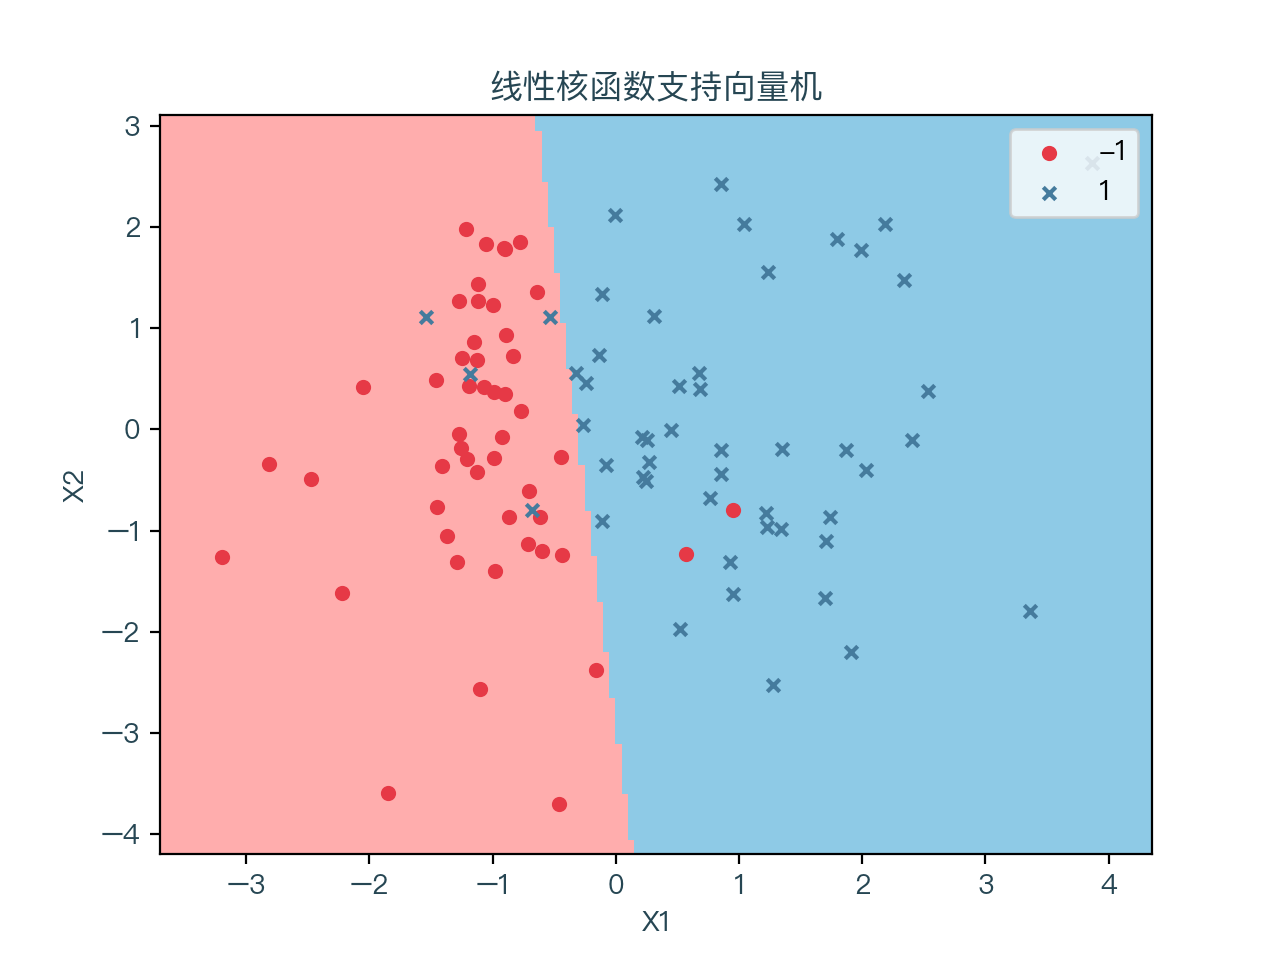

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = linearSmo.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('线性核函数支持向量机', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper right")
plt.show()

线性核函数支持向量机（scikit-learn）：

In [9]:
from sklearn.svm import SVC

# 线性核函数支持向量机
svc = SVC(kernel = "linear")
# 拟合数据
svc.fit(X, y)

SVC(kernel='linear')

线性核函数支持向量机可视化（scikit-learn）：

<IPython.core.display.Javascript object>


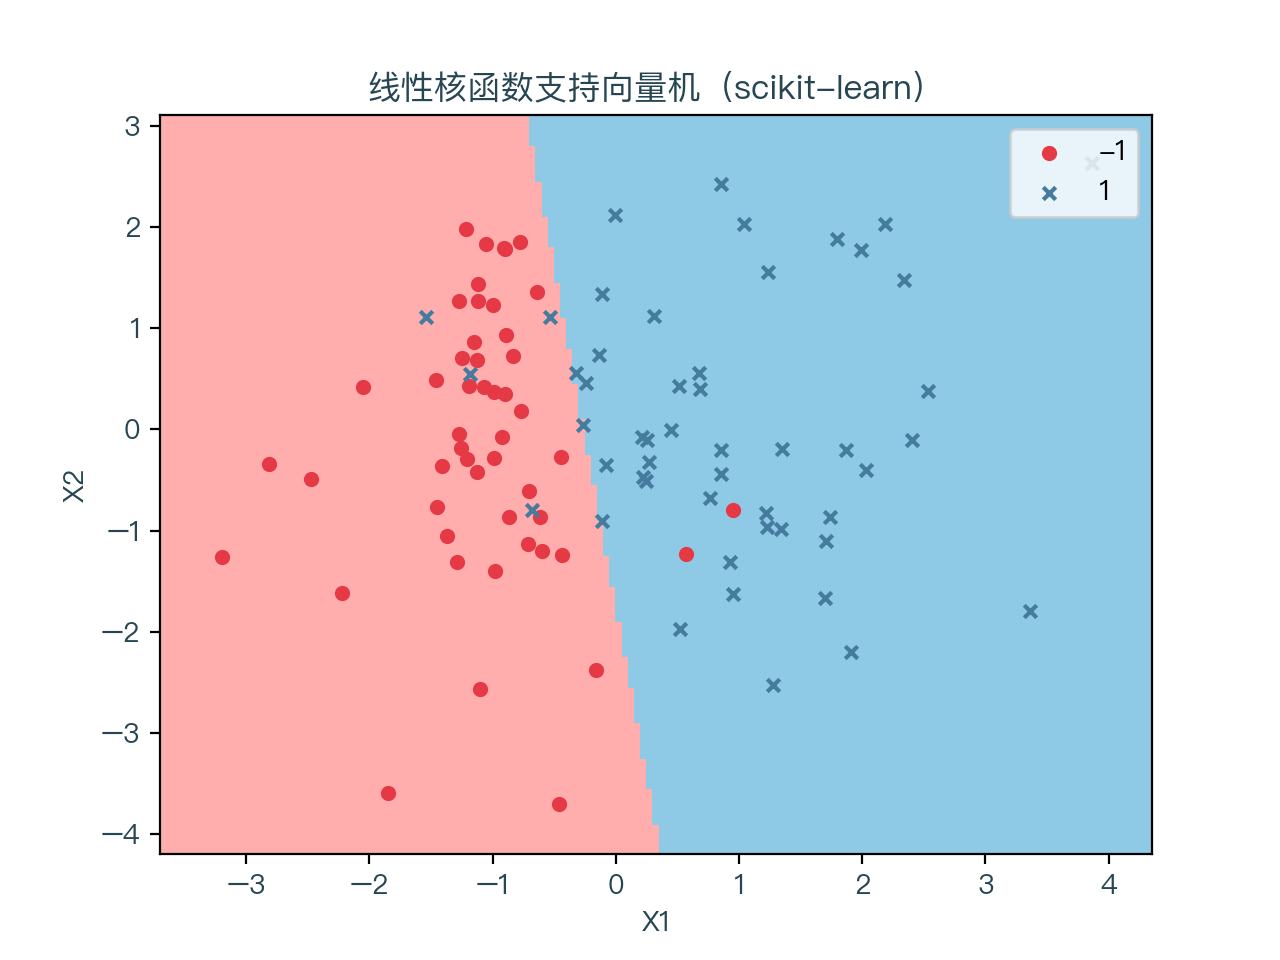

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('线性核函数支持向量机（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper right")
plt.show()

多项式核函数支持向量机：

In [11]:
# 多项式核函数支持向量机
def polynomialKernel(x, z, degree = 3, coef0 = 0.0, gamma = 1.0):
    return np.power(gamma * x.dot(z) + coef0, degree)

polynomialSmo = SMO(X, y, kernel = polynomialKernel)
polynomialSmo.fit()

多项式核函数支持向量机可视化：

<IPython.core.display.Javascript object>


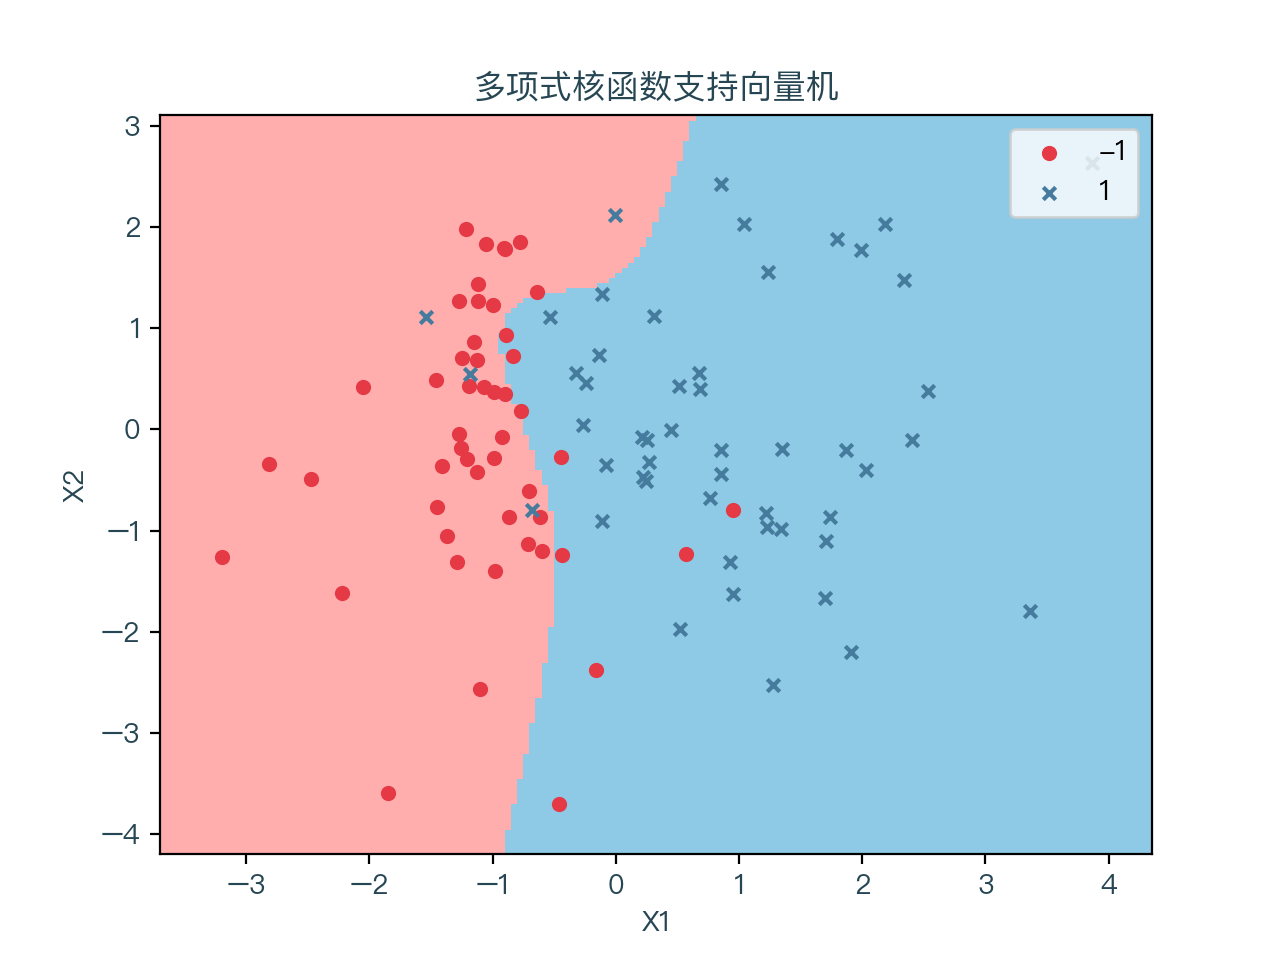

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = polynomialSmo.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('多项式核函数支持向量机', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper right")
plt.show()

多项式核函数支持向量机（scikit-learn）：

In [13]:
from sklearn.svm import SVC

# 多项式核函数支持向量机
svc = SVC(kernel = "poly", gamma = 1)
# 拟合数据
svc.fit(X, y)

SVC(gamma=1, kernel='poly')

多项式核函数支持向量机可视化（scikit-learn）：

<IPython.core.display.Javascript object>


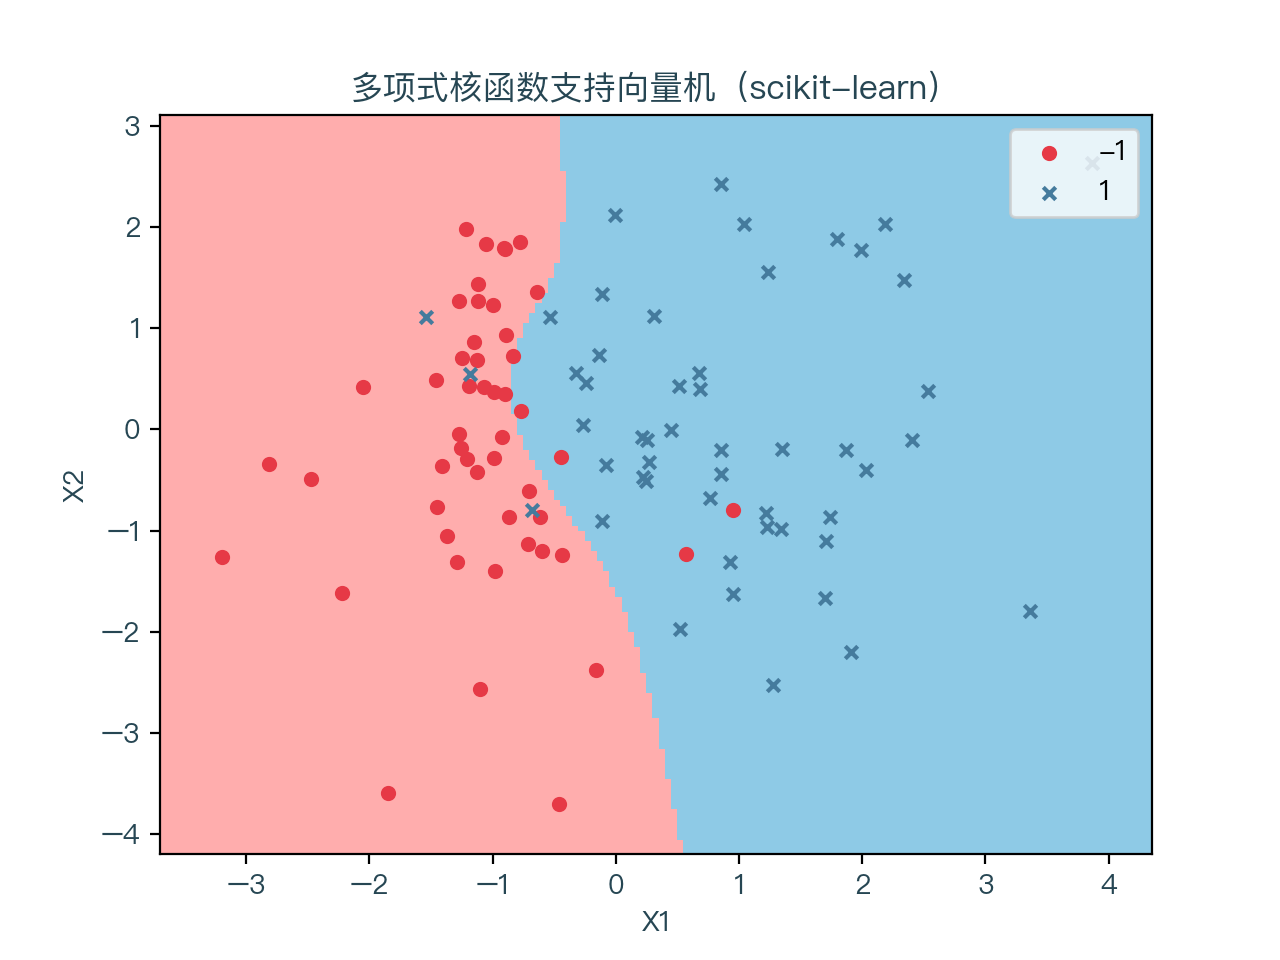

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('多项式核函数支持向量机（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper right")
plt.show()

径向基核函数支持向量机：

In [15]:
# 径向基核函数支持向量机
def rbfKernel(x, z, degree = 3, coef0 = 0.0, gamma = 1.0):
    return np.exp(-gamma * np.power(np.linalg.norm(x - z), 2))

rbfSmo = SMO(X, y, kernel = rbfKernel)
rbfSmo.fit()

径向基核函数支持向量机可视化：

<IPython.core.display.Javascript object>


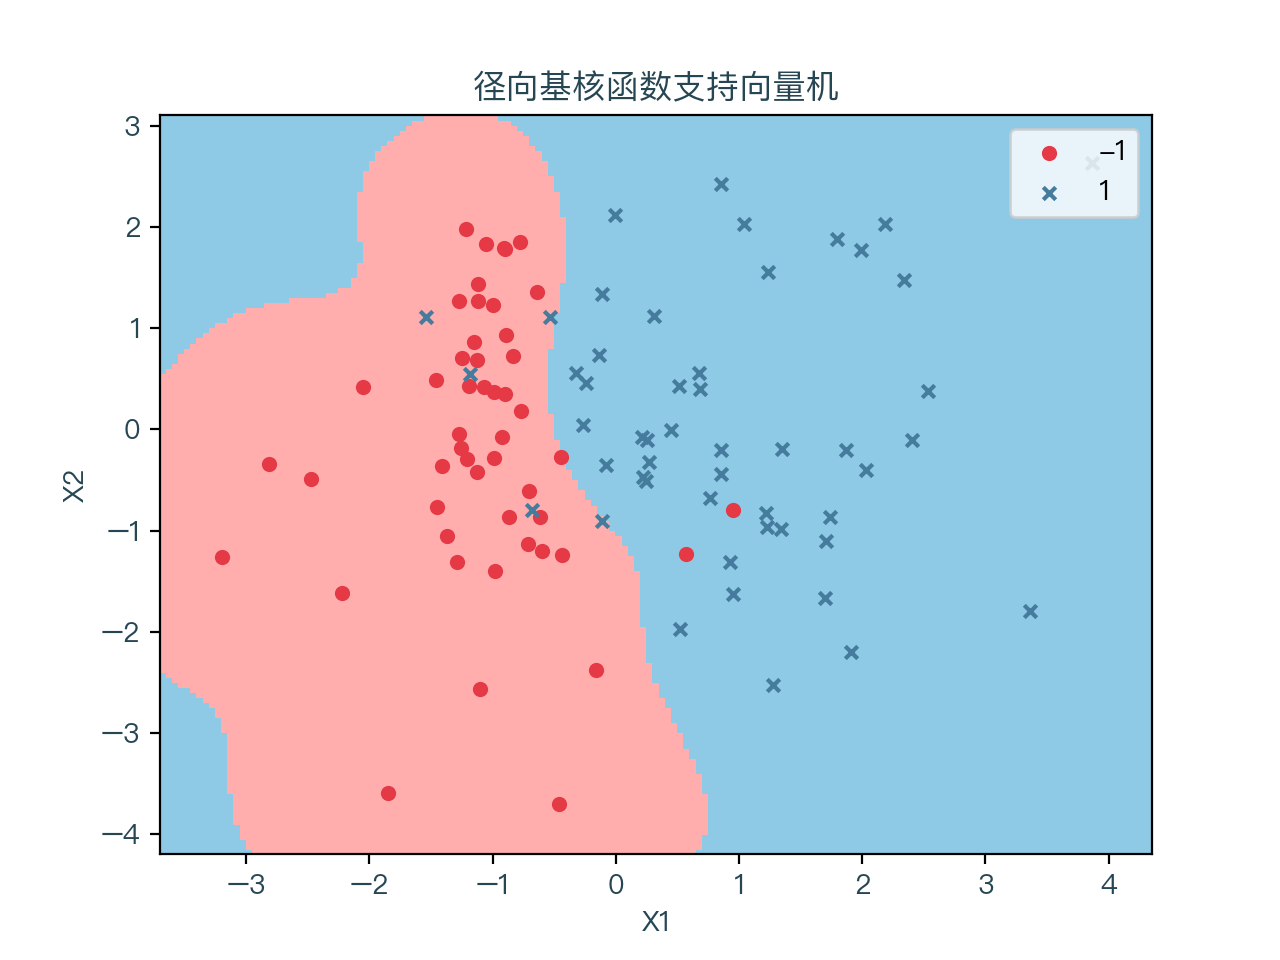

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = rbfSmo.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('径向基核函数支持向量机', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper right")
plt.show()

径向基核函数支持向量机（scikit-learn）：

In [17]:
from sklearn.svm import SVC

# 径向基核函数支持向量机
svc = SVC(kernel = "rbf", gamma = 1)
# 拟合数据
svc.fit(X, y)

SVC(gamma=1)

径向基核函数支持向量机可视化（scikit-learn）：

<IPython.core.display.Javascript object>


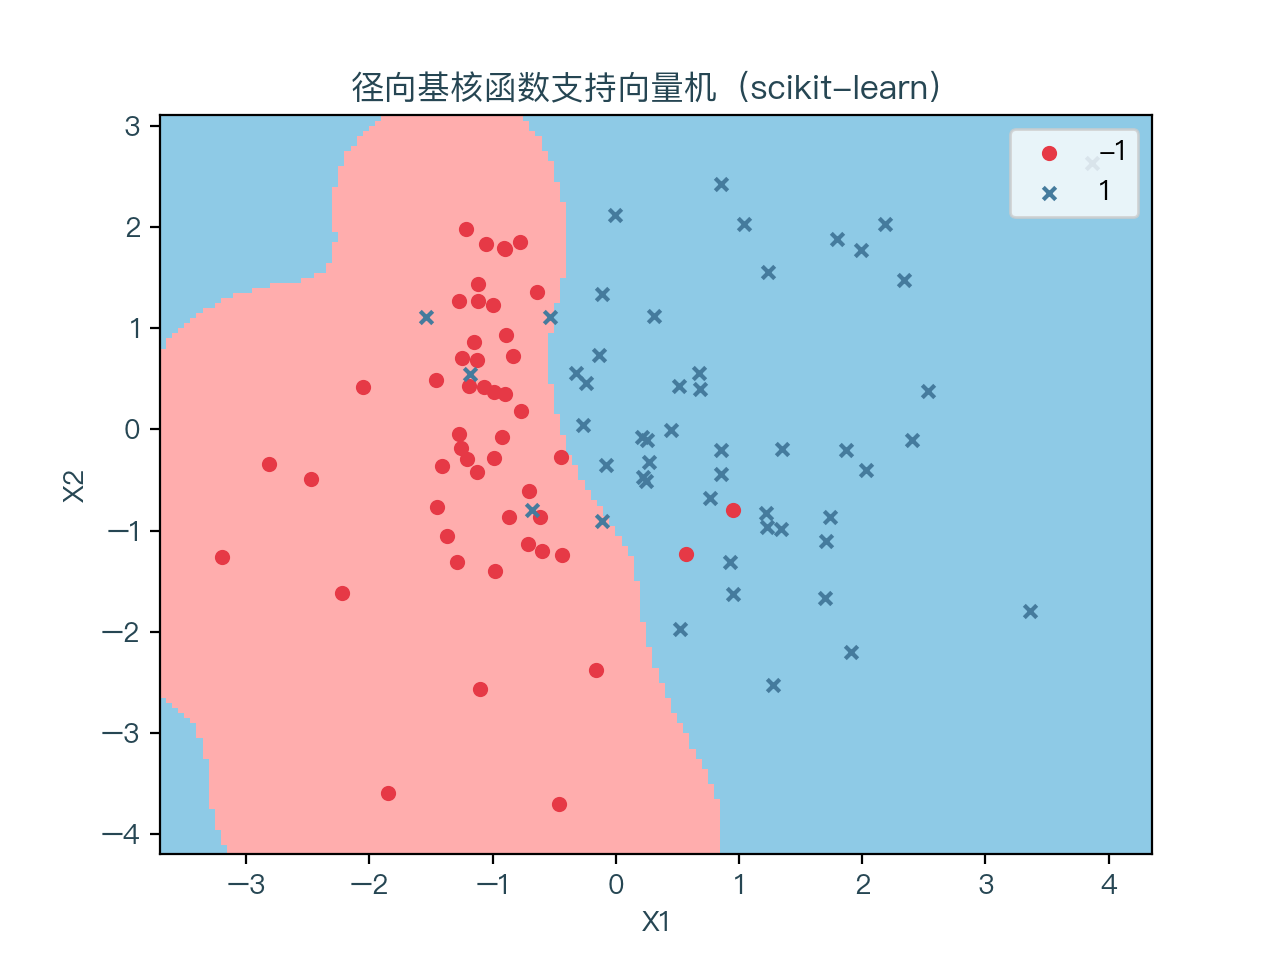

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('径向基核函数支持向量机（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper right")
plt.show()